## Base Model using CIFAR-10 Image Data

In [ ]:
# !pip install np_utils

In [57]:
# !pip show keras # 2.15.0

In [ ]:
# https://github.com/ak811/kcnn/blob/master/src/CNN_CIFAR10.py

In [100]:
import seaborn as sn
import pandas  as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from tensorflow.keras.constraints import max_norm
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import classification_report
from time import time

In [91]:
# 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [92]:
x_train.size, y_train.size, x_test.size, y_test.size

(153600000, 50000, 30720000, 10000)

In [94]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
x_train = x_train / 255
x_test = x_test / 255

In [95]:
x_train.shape[1:]

(32, 32, 3)

In [153]:
def plot_accuracy_loss(history, epochs):
    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Loss')
    plt.grid(False)
    plt.show()
    plt.close('all')

In [154]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [155]:
# test model on new image
img_path = 'images/airplane_test_img.jpeg'
img = tf.keras.utils.load_img(img_path, color_mode='rgb', target_size=(32, 32))
img_arr = tf.keras.utils.img_to_array(img)
img_arr = np.array([img_arr])

In [156]:
def get_new_image_predictions(model, img_arr):
    return model.predict(img_arr)

In [157]:
def plot_airplane_predictions(img_prediction, class_names, model_name):
    min_pred = np.min(img_prediction[0])
    max_pred = np.max(img_prediction[0])
    scaled_pred = (img_prediction[0] - min_pred)/(max_pred - min_pred)

    fig, ax = plt.subplots()
    ax.bar(class_names, scaled_pred)
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Airplane Prediction {model_name}')
    
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()
    plt.close('all')

# ---------- Base Model ----------

In [101]:
# https://ermlab.com/en/blog/nlp/cifar-10-classification-using-keras-tutorial/
def build_base_model():
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=max_norm(2.)))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [102]:
model_base = build_base_model()
# stochastic gradient descent optimizer
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

start_time = time()
model_base.compile(loss='categorical_crossentropy', optimizer=sgd, 
                   metrics=['accuracy','binary_accuracy','categorical_accuracy','categorical_crossentropy'])
end_time = time() - start_time
print(f'Base Model took {end_time} seconds to fit')
model_base.summary()

Base Model took 0.002666950225830078 seconds to fit
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_23 (Dropout)        (None, 16, 16, 64)        0         
 

In [103]:
start_time = time()
history_base_model = model_base.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test,y_test), shuffle=True, verbose=0)
end_time = time() - start_time
print(f'Base Model took {end_time} seconds to fit')


Base Model took 2965.3578629493713 seconds to fit


In [104]:
start_time = time()
model_base_score = model_base.evaluate(x_test, y_test, verbose=0)
model_base_score_time = time() - start_time
print(f'model_base took {model_base_score_time} seconds to score')

model_base took 3.3748559951782227 seconds to score


In [ ]:
predictions = model_base.predict(x_test)
predictions[0]

In [158]:
model_base_score_dict = dict(zip(model_base.metrics_names, model_base_score))
model_base_score_dict

{'loss': 0.8881654143333435,
 'accuracy': 0.7093999981880188,
 'binary_accuracy': 0.9476704001426697,
 'categorical_accuracy': 0.7093999981880188,
 'categorical_crossentropy': 0.8881654143333435}

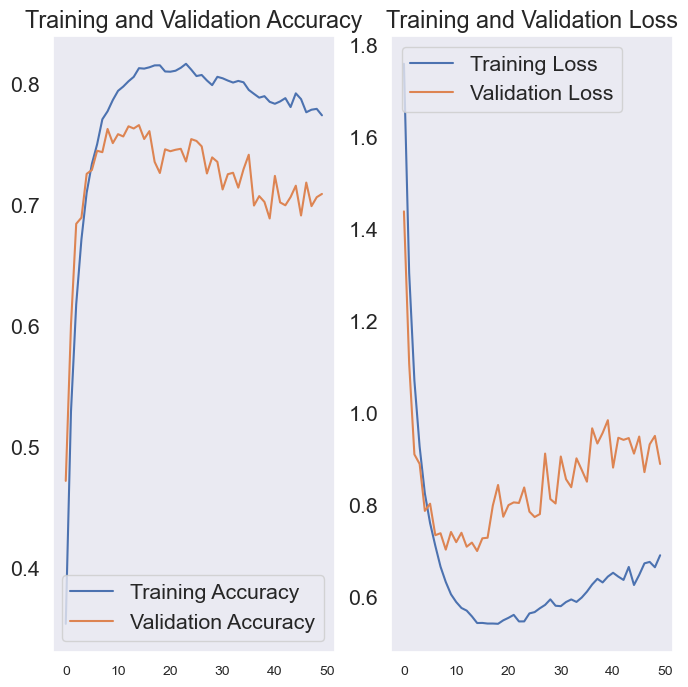

In [159]:
plot_accuracy_loss(history_base_model, 50)

1/1 [==============================] - 0s 65ms/step


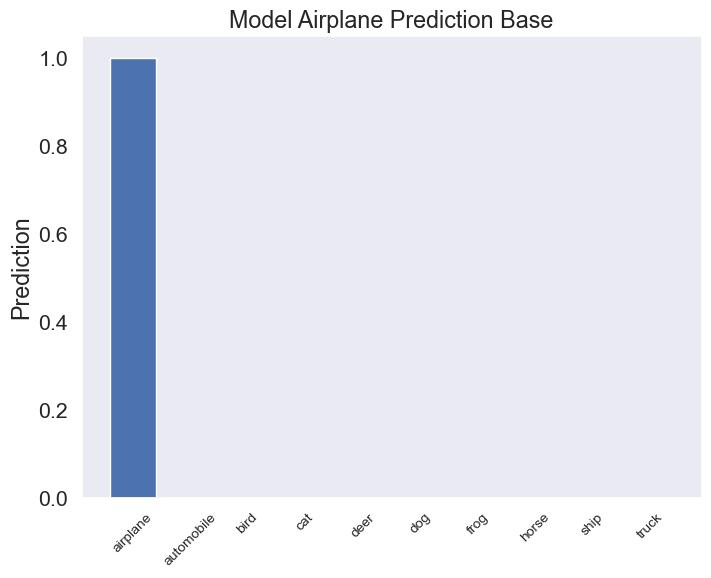

In [160]:
base_prediction = get_new_image_predictions(model_base, img_arr)
plot_airplane_predictions(base_prediction, class_names, 'Base')

In [161]:
df_base = pd.DataFrame([model_base_score_dict]
)
row_names = {
    0:'Base Model'
}
df_base.rename(index=row_names, inplace=True)
df_base

,loss,accuracy,binary_accuracy,categorical_accuracy,categorical_crossentropy
Base Model,0.888165,0.7094,0.94767,0.7094,0.888165
